In [1]:
# LIBRERÍAS UTILIZADAS EN EL CÓDIGO

# -------------------- LIBRERÍAS GENERALES --------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- PREPROCESAMIENTO DE DATOS --------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

# -------------------- EVALUACIÓN DE MODELOS --------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer

from sklearn.inspection import permutation_importance

# -------------------- SELECCIÓN Y AJUSTE DE MODELOS --------------------
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import learning_curve

# -------------------- MODELOS ESPECÍFICOS --------------------

# REGRESIÓN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
# REDES NEURONALES
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
#PREPROCESAMIENTO Y CARGA DE DATOS

In [3]:
# Cargar los datos
file_path = "C:/Users/david/Desktop/PRUEBAMODELOSBIEN.xlsx"
data = pd.read_excel(file_path)

In [4]:
# Seleccionar columnas relevantes para nuestro modelo
columnas_relevantes = [
    "activity", "Technique", "W.E", "sweat_ph",
     "glucose(µM)", "blood_glucose"
]

#    "body_temperature", "physical_activity", "fast",
data = data[data["Valid"] == "YES"][columnas_relevantes]

In [5]:
display(data)

,activity,Technique,W.E,sweat_ph,glucose(µM),blood_glucose
0,bike,OCP,PtPaste,NaN,173.8,NaN
4,crossfit,OCP,PtPaste,NaN,177.2,NaN
6,crossfit,OCP,PtPaste,NaN,118.6,NaN
9,bike,OCP,PtPaste,NaN,85.4,87.0
10,bike,OCP,PtPaste,NaN,98.5,90.0
...,...,...,...,...,...,...
131,Running,current,PtPaste,NaN,71.0,83.0
132,Running,current,PtPaste,NaN,90.8,83.0
133,Running,current,PtPaste,NaN,56.4,NaN
134,Running,current,PtPaste,NaN,67.2,99.0


In [6]:
#conversion de glucosa mg/dL a µM/L
data["blood_glucose"] = data["blood_glucose"] *55.6
data["glucose(µM)"] = data["glucose(µM)"] 

In [7]:
display(data)

,activity,Technique,W.E,sweat_ph,glucose(µM),blood_glucose
0,bike,OCP,PtPaste,NaN,173.8,NaN
4,crossfit,OCP,PtPaste,NaN,177.2,NaN
6,crossfit,OCP,PtPaste,NaN,118.6,NaN
9,bike,OCP,PtPaste,NaN,85.4,4837.2
10,bike,OCP,PtPaste,NaN,98.5,5004.0
...,...,...,...,...,...,...
131,Running,current,PtPaste,NaN,71.0,4614.8
132,Running,current,PtPaste,NaN,90.8,4614.8
133,Running,current,PtPaste,NaN,56.4,NaN
134,Running,current,PtPaste,NaN,67.2,5504.4


In [8]:
# Reemplazar "NULL" por NaN y manejar valores faltantes
data.replace("NULL", np.nan, inplace=True)
for col in data.columns:
    if data[col].dtype == "object":
        data[col] = data[col].fillna(data[col].mode()[0])  # Rellenar con la moda
    else:
        data[col] = data[col].fillna(data[col].mean())  # Rellenar con la media

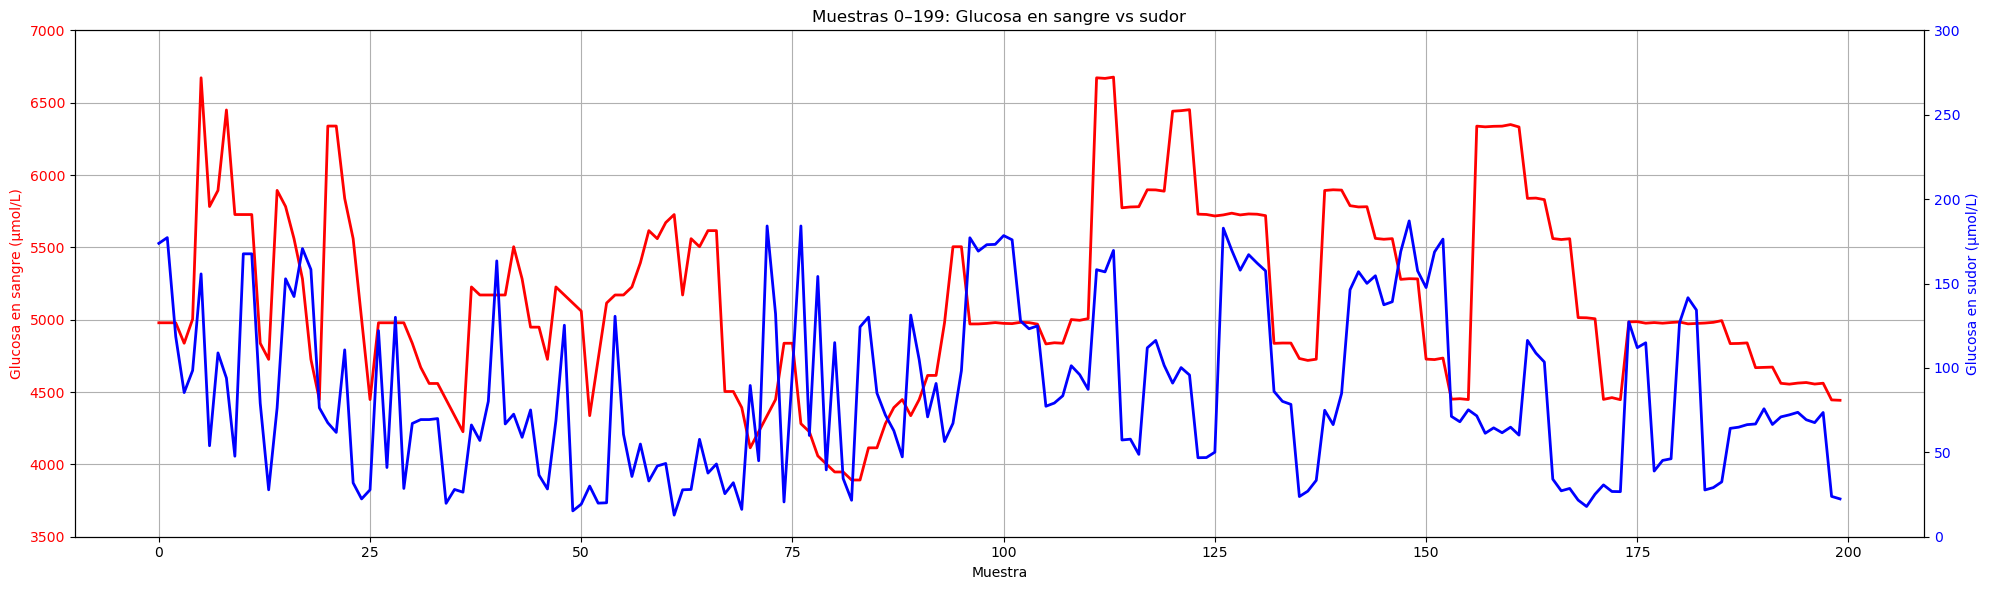

In [189]:
# Dividir el DataFrame en dos partes
data_1 = data.iloc[:200]

# ----------- Primer gráfico (muestras 0–199) -----------
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.plot(data_1.index, data_1["blood_glucose"], color='red', linewidth=2, label="Glucosa en sangre (µmol/L)")
ax1.set_xlabel("Muestra")
ax1.set_ylabel("Glucosa en sangre (µmol/L)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylim(3500, 7000)

ax2 = ax1.twinx()
ax2.plot(data_1.index, data_1["glucose(µM)"], color='blue', linewidth=2, label="Glucosa en sudor (µmol/L)")
ax2.set_ylabel("Glucosa en sudor (µmol/L)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 300)

plt.title("Muestras 0–199: Glucosa en sangre vs sudor")
ax1.grid(True)
fig.tight_layout()
plt.show()


In [10]:
# Convertir variables categóricas a numéricas
cat_features = ["activity", "Technique", "W.E"]
data = pd.get_dummies(data, columns=cat_features, drop_first=True)

In [11]:
# Número de réplicas sintéticas por fila original
replicas_por_fila = 3

# Lista para guardar nuevos datos
augmented_data = []

for _, row in data.iterrows():
    for _ in range(replicas_por_fila):
        new_row = row.copy()
        
        # Ruido fisiológicamente plausible
        if not pd.isna(row["glucose(µM)"]):
            new_row["glucose(µM)"] = round(
                row["glucose(µM)"] * np.random.uniform(0.9, 1.1) + np.random.normal(0, 2), 1
            )
        
        if not pd.isna(row["blood_glucose"]):
            new_row["blood_glucose"] = round(
                row["blood_glucose"] + np.random.normal(0, 5), 1
            )

        if not pd.isna(row["sweat_ph"]):
            new_row["sweat_ph"] = round(
                row["sweat_ph"] + np.random.normal(0, 0.1), 2
            )
        
        augmented_data.append(new_row)

# Crear DataFrame sintético
df_augmented = pd.DataFrame(augmented_data)

# Juntar con los datos originales
data = pd.concat([data, df_augmented], ignore_index=True)


In [12]:
#Visualización de los datos
display(data)

,sweat_ph,glucose(µM),blood_glucose,activity_Running,activity_bike,activity_crossfit,Technique_current
0,5.919565,173.8,4978.727273,False,True,False,False
1,5.919565,177.2,4978.727273,False,False,True,False
2,5.919565,118.6,4978.727273,False,False,True,False
3,5.919565,85.4,4837.200000,False,True,False,False
4,5.919565,98.5,5004.000000,False,True,False,False
...,...,...,...,...,...,...,...
379,5.950000,72.7,5508.400000,True,False,False,True
380,5.880000,68.5,5504.000000,True,False,False,True
381,5.940000,103.2,5500.400000,True,False,False,True
382,6.050000,97.0,5512.700000,True,False,False,True


In [13]:
#CALCULO DE LA MATRIZ DE CORRELACIÓN DE PEARSON

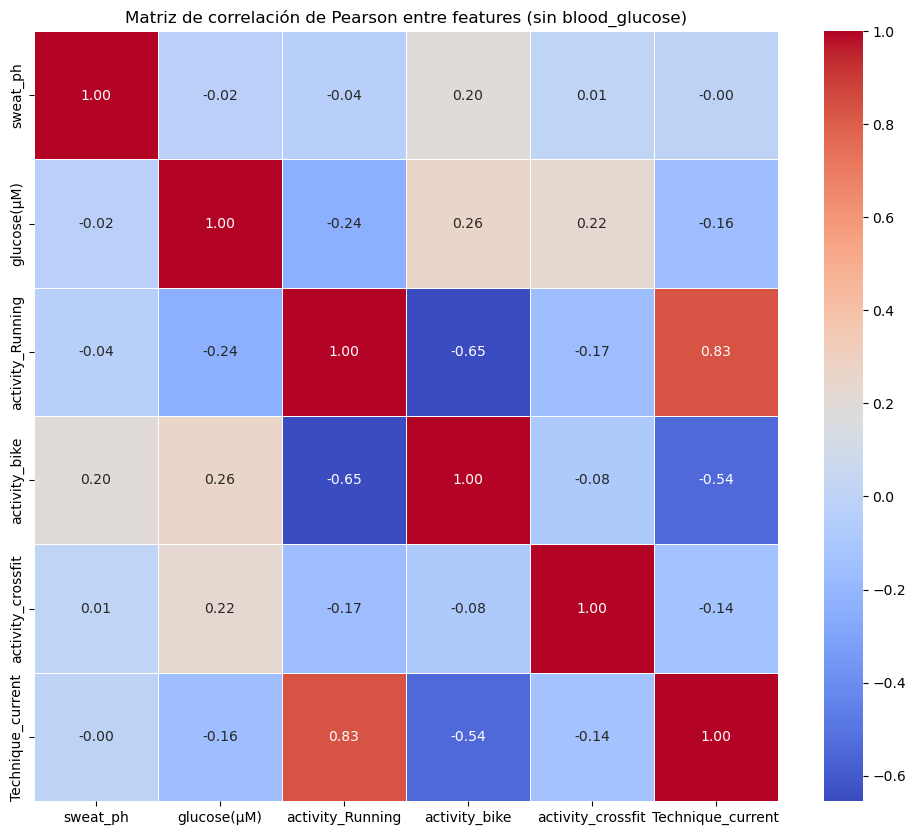

In [14]:
# Excluir la variable objetivo para ver correlaciones entre features
features_only = data.drop(columns=["blood_glucose"])
correlation_matrix_features = features_only.corr()

# Mapa de calor de correlaciones entre features (sin blood_glucose)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_features, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación de Pearson entre features (sin blood_glucose)')
plt.show()

In [15]:
# Función para eliminar variables con alta correlación entre sí
def eliminar_variables_correlacionadas(df, target_column, threshold=0.85):
    df = df.copy()
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = []
    for column in upper.columns:
        if column != target_column:
            if any(upper[column] > threshold):
                to_drop.append(column)

    print(f"Variables eliminadas por alta correlación: {to_drop}")
    return df.drop(columns=to_drop)

In [16]:
# Eliminar variables redundantes por alta correlación
data = eliminar_variables_correlacionadas(data, target_column="blood_glucose")

Variables eliminadas por alta correlación: []


In [17]:
# Definir variables de entrada y salida
X = data.drop(columns=["blood_glucose"])
y = data["blood_glucose"]

In [18]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Escalado de los datos para algunos modelos (SVM, ANN, KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
results = []

In [21]:
# ------------------- MODELO 1: XGBoost -------------------

In [22]:
# Crear y entrenar el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.2, max_depth=3)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [23]:
#BUSCAMOS LOS MEJORES PARAMETROS PARA EL MODELO
# Definir la cuadrícula de hiperparámetros

param_grid = {
#    'n_estimators': [50, 100, 200],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'max_depth': [3, 5, 7],
#    'subsample': [0.6, 1.0],
#    'colsample_bytree': [0.6, 0.8],
#    'reg_alpha': [0.01, 0.1],
#    'reg_lambda': [0.5, 1.0]
#}

    'n_estimators': [250, 300, 400],
    'learning_rate': [0.01, 0.03],
    'max_depth': [2, 3],  # Manténlo pequeño
    'subsample': [0.6, 0.8],  # Introduce aleatoriedad
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [10.0, 15.0],
    'reg_lambda': [5.0, 7.5, 10.0],
    'gamma': [0, 1, 5]  # Para hacer split más conservador
}
# Búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print(f'Mejores hiperparámetros: {grid_search.best_params_}')
best_model = grid_search.best_estimator_ # Obtener el mejor modelo de GridSearchCV

Mejores hiperparámetros: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 15.0, 'reg_lambda': 7.5, 'subsample': 0.8}


In [24]:
# Realizar una validación cruzada con los mejores hiperparámetros encontrados para obtener una estimación más robusta del rendimiento del modelo.
scores = cross_val_score(best_model, X, y, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
print(f'MAE promedio (validación cruzada): {-scores.mean()}')
print(f"MAE std: {scores.std():.4f}")

MAE promedio (validación cruzada): 436.69751748371556
MAE std: 131.5389


In [25]:
# Predicciones en el conjunto de entrenamiento y prueba
y_pred_train = best_model.predict(X_train)
y_pred_testXGB = best_model.predict(X_test)

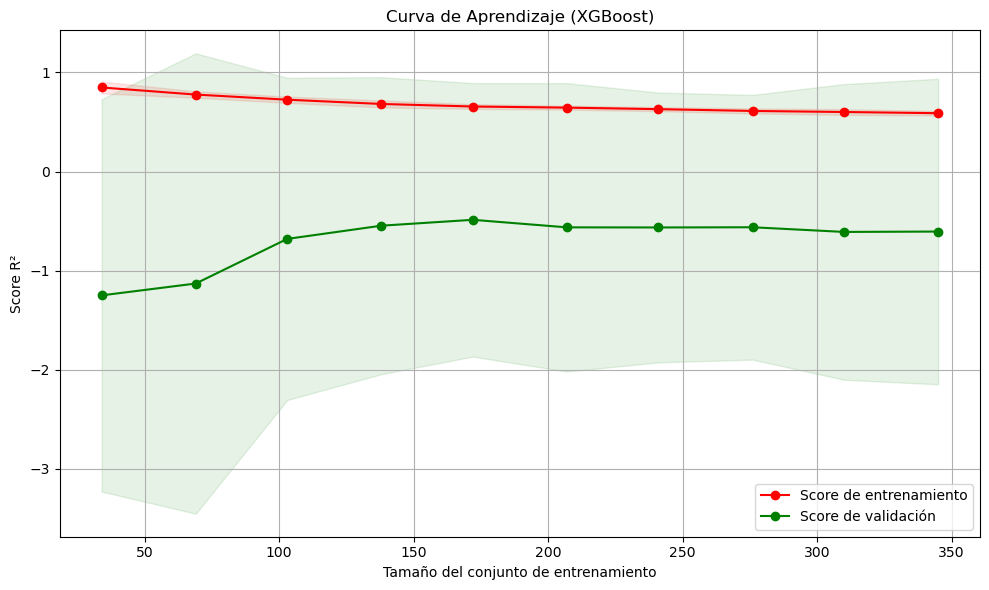

In [26]:
# Generar curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    scoring='r2',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Calcular media y desviación estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de entrenamiento")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validación")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.title("Curva de Aprendizaje (XGBoost)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
#EVALUACIÓN DEL MODELO

In [28]:
# Evaluación del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

# Evaluación del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_pred_testXGB)
r2_test = r2_score(y_test, y_pred_testXGB)
mse_test = mean_squared_error(y_test, y_pred_testXGB)

# Calcular RMSE y MAPE
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_testXGB)

print(f"Evaluación en Conjunto de Entrenamiento:")
print(f"MAE: {mae_train:.2f}, R²: {r2_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}")

print(f"\nEvaluación en Conjunto de Prueba:")
print(f"MAE: {mae_test:.2f}, R²: {r2_test:.2f}, MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}")

Evaluación en Conjunto de Entrenamiento:
MAE: 309.59, R²: 0.58, MSE: 157553.22, RMSE: 396.93, MAPE: 0.06

Evaluación en Conjunto de Prueba:
MAE: 340.78, R²: 0.47, MSE: 204175.82, RMSE: 451.86, MAPE: 0.07


In [29]:
# Añadir resultados a una lista de resultados
results.append({
    "Modelo": "XGBoost",  
    
    "MAE Train": mae_train,
    "MSE Train": mse_train,
    "RMSE Train": rmse_train,
    "R2 Train": r2_train,
    "MAPE Train": mape_train,

    "MAE Test": mae_test,
    "MSE Test": mse_test,
    "RMSE Test": rmse_test,
    "R2 Test": r2_test,
    "MAPE Test": mape_test
})


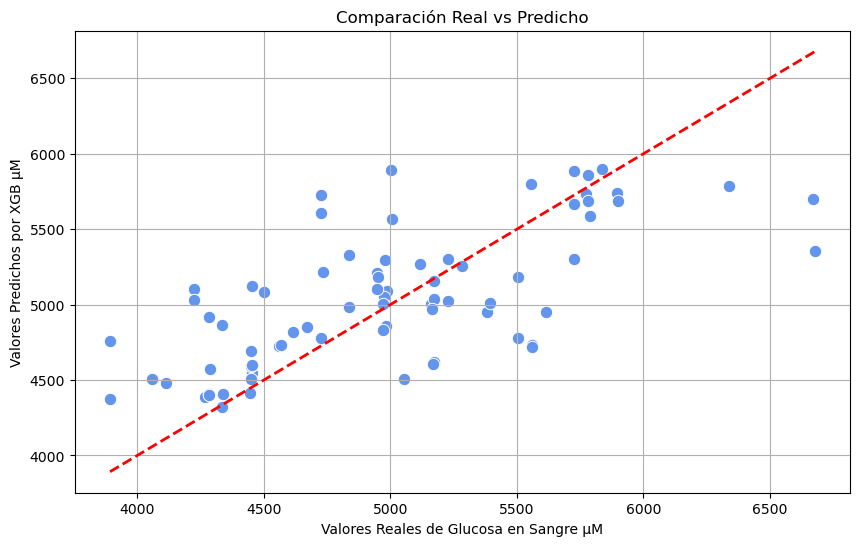

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_testXGB, color="#6495ED", edgecolor="white", s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales de Glucosa en Sangre µM")
plt.ylabel("Valores Predichos por XGB µM")
plt.title("Comparación Real vs Predicho")
plt.grid(True)
plt.show()

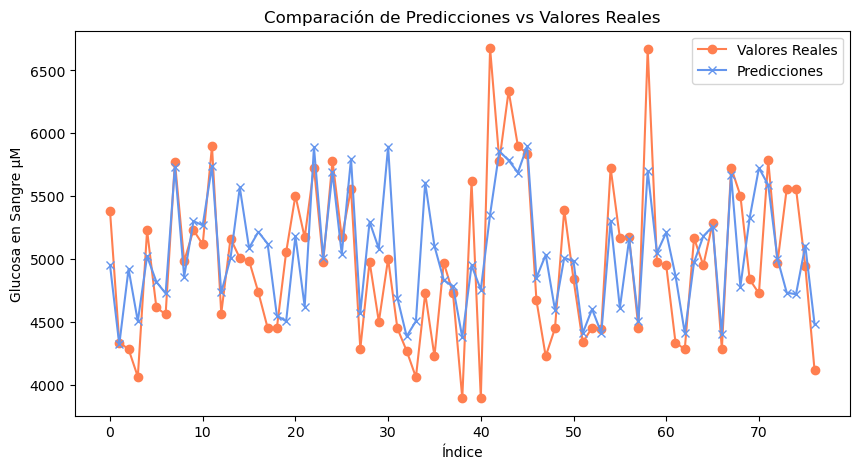

In [31]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Valores Reales", marker='o', color="#FF7F50")
plt.plot(y_pred_testXGB, label="Predicciones", marker='x', color="#6495ED")
plt.legend()
plt.xlabel("Índice")
plt.ylabel("Glucosa en Sangre µM")
plt.title("Comparación de Predicciones vs Valores Reales")
plt.show()

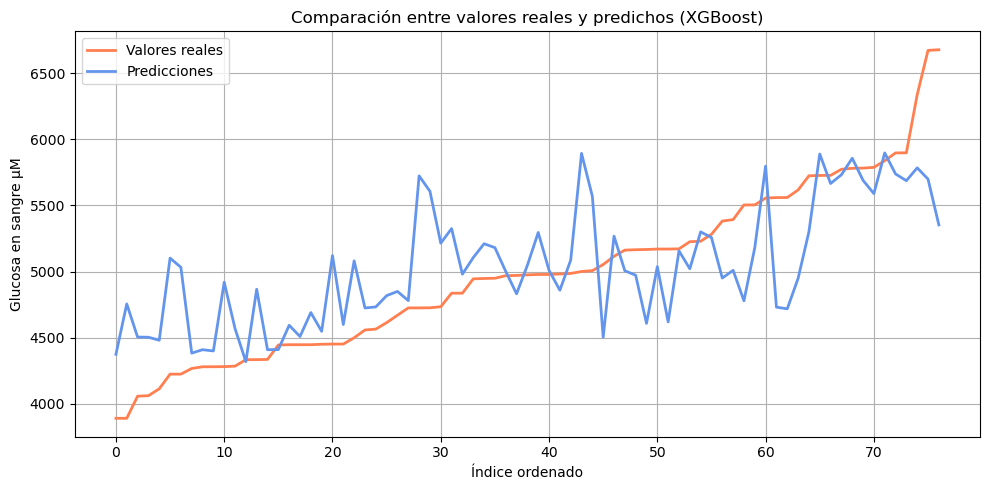

In [32]:
# Ordenar los valores por los reales para una mejor visualización lineal
sorted_indices = np.argsort(y_test)
y_test_sorted = np.array(y_test)[sorted_indices]
y_pred_sorted = y_pred_testXGB[sorted_indices]

# Crear la gráfica lineal
plt.figure(figsize=(10, 5))
plt.plot(y_test_sorted, label='Valores reales', linewidth=2, color="#FF7F50")
plt.plot(y_pred_sorted, label='Predicciones', linewidth=2, color="#6495ED")
plt.title('Comparación entre valores reales y predichos (XGBoost)')
plt.xlabel('Índice ordenado')
plt.ylabel('Glucosa en sangre µM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

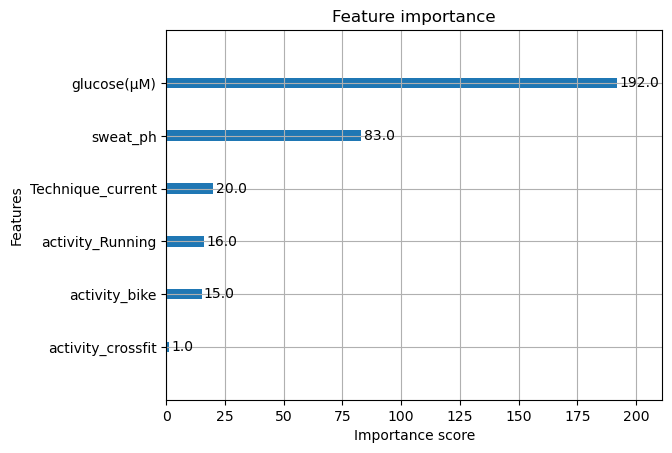

In [33]:
# Importancia de las características
xgb.plot_importance(model)
plt.show()

In [34]:
# ------------------- MODELO 2: SVR -------------------

In [35]:
# Entrenar el modelo SVR
svr = SVR(kernel='linear', C=1, gamma=0.1, epsilon=0.2)
svr.fit(X_train_scaled, y_train)


SVR(C=1, epsilon=0.2, gamma=0.1, kernel='linear')

In [36]:
# BÚSQUEDA DE HIPERPARÁMETROS (GridSearchCV)
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],  
    'C': [0.1, 1, 10, 50, 100],           
    'epsilon': [0.01, 0.05, 0.1, 0.2],    
    'gamma': ['scale', 'auto', 0.01, 0.1] 
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=0)
grid_search.fit(X_train_scaled, y_train)

print(f"Mejores Hiperparámetros: {grid_search.best_params_}")
best_svr = grid_search.best_estimator_  # El mejor modelo

Mejores Hiperparámetros: {'C': 100, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}


In [37]:
# VALIDACIÓN CRUZADA 
# Para una estimación más robusta del rendimiento
cv_scores = cross_val_score(best_svr, X_scaled, y, cv=10, scoring='neg_mean_absolute_error')
print(f"MAE Promedio (CV): {-cv_scores.mean():.2f}")
print(f"MAE std: {cv_scores.std():.4f}")

MAE Promedio (CV): 435.00
MAE std: 105.2811


In [38]:
# PREDICCIONES con el MEJOR MODELO
y_pred_train = best_svr.predict(X_train_scaled)
y_pred_testSVR = best_svr.predict(X_test_scaled)

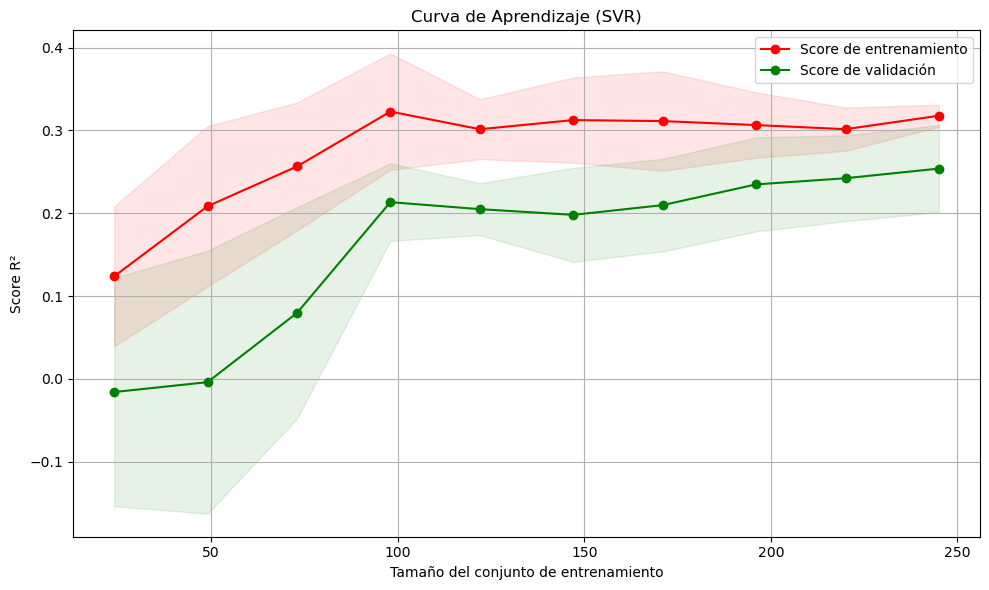

In [39]:
# Generar curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_svr,  # Usar el MEJOR modelo SVR
    X=X_train_scaled,  # Usar X_train_scaled
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='r2',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de entrenamiento")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validación")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.title("Curva de Aprendizaje (SVR)")  # Cambiar el título
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
#EVALUACIÓN DEL MODELO

In [41]:
# Evaluación del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

# Evaluación del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_pred_testSVR)
r2_test = r2_score(y_test, y_pred_testSVR)
mse_test = mean_squared_error(y_test, y_pred_testSVR)

# Calcular RMSE y MAPE
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_testSVR)

print(f"Evaluación en Conjunto de Entrenamiento:")
print(f"MAE: {mae_train:.2f}, R²: {r2_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}")

print(f"\nEvaluación en Conjunto de Prueba:")
print(f"MAE: {mae_test:.2f}, R²: {r2_test:.2f}, MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}")

Evaluación en Conjunto de Entrenamiento:
MAE: 395.37, R²: 0.32, MSE: 254945.74, RMSE: 504.92, MAPE: 0.08

Evaluación en Conjunto de Prueba:
MAE: 343.52, R²: 0.49, MSE: 195817.47, RMSE: 442.51, MAPE: 0.07


In [42]:
# Añadir resultados a una lista de resultados
results.append({
    "Modelo": "SVR",  
    
    "MAE Train": mae_train,
    "MSE Train": mse_train,
    "RMSE Train": rmse_train,
    "R2 Train": r2_train,
    "MAPE Train": mape_train,

    "MAE Test": mae_test,
    "MSE Test": mse_test,
    "RMSE Test": rmse_test,
    "R2 Test": r2_test,
    "MAPE Test": mape_test
})


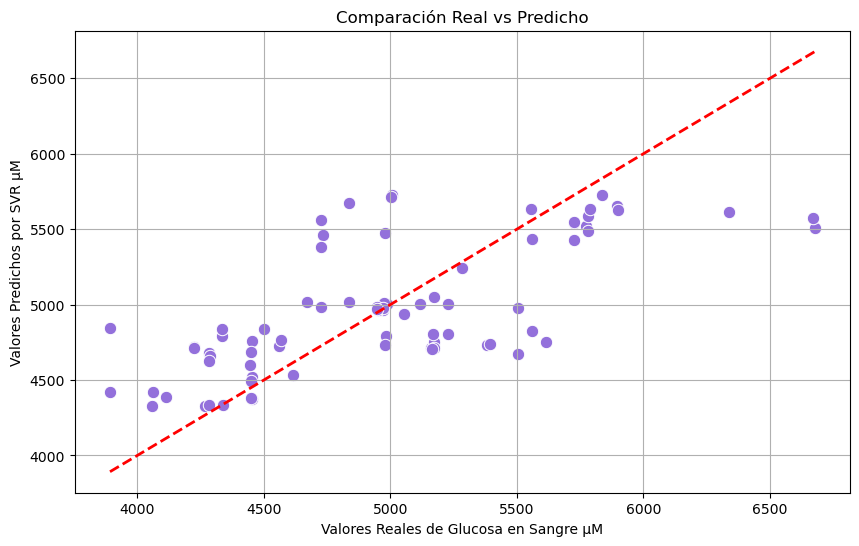

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_testSVR, color="#9370DB", edgecolor="white", s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales de Glucosa en Sangre µM")
plt.ylabel("Valores Predichos por SVR µM")
plt.title("Comparación Real vs Predicho")
plt.grid(True)
plt.show()

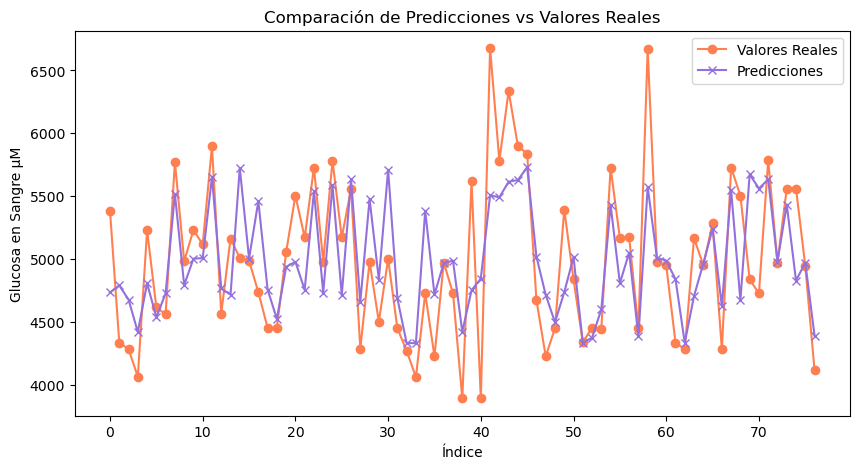

In [44]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Valores Reales", marker='o', color="#FF7F50")
plt.plot(y_pred_testSVR, label="Predicciones", marker='x', color="#9370DB")
plt.legend()
plt.xlabel("Índice")
plt.ylabel("Glucosa en Sangre µM")
plt.title("Comparación de Predicciones vs Valores Reales")
plt.show()

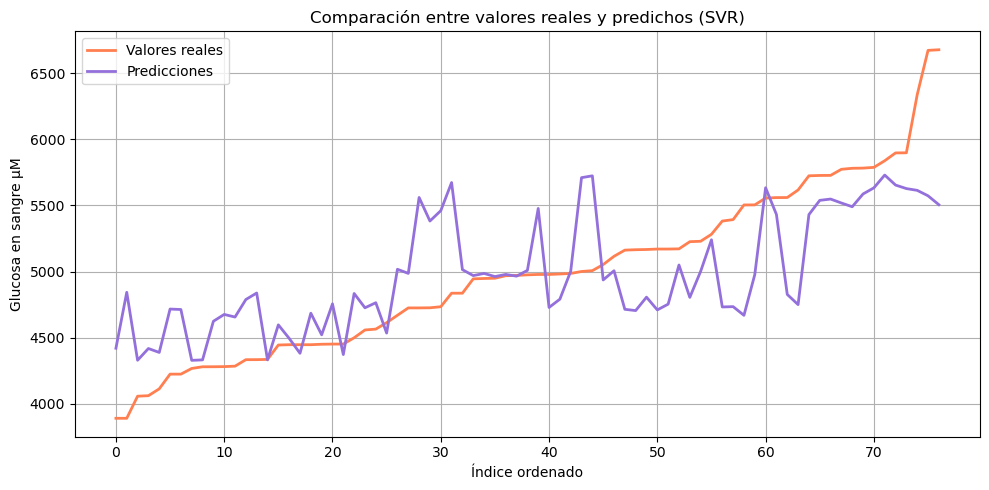

In [45]:
# Ordenar los valores por los reales para una mejor visualización
sorted_indices = np.argsort(y_test)
y_test_sorted = np.array(y_test)[sorted_indices]
y_pred_sorted = y_pred_testSVR[sorted_indices]

# Crear la gráfica lineal
plt.figure(figsize=(10, 5))
plt.plot(y_test_sorted, label='Valores reales', linewidth=2, color="#FF7F50")
plt.plot(y_pred_sorted, label='Predicciones', linewidth=2, color="#9370DB")
plt.title('Comparación entre valores reales y predichos (SVR)')
plt.xlabel('Índice ordenado')
plt.ylabel('Glucosa en sangre µM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
# Importancia por permutación para SVR
result_svr = permutation_importance(svr, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')

# Mostrar resultados ordenados
sorted_idx = result_svr.importances_mean.argsort()[::-1]
for i in sorted_idx:
    print(f"{X.columns[i]}: {result_svr.importances_mean[i]:.4f}")

Technique_current: 18.8704
activity_bike: 13.4826
activity_Running: 3.9218
activity_crossfit: 0.1321
sweat_ph: -0.0247
glucose(µM): -0.4695


In [47]:
# ------------------- MODELO 3: ANN -------------------

In [48]:
def build_model(neurons_1=64, neurons_2=32, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(units=neurons_1, activation='relu'))
    model.add(Dense(units=neurons_2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [49]:
# Crear el objeto KerasRegressor usando scikeras
model = KerasRegressor(model=build_model, verbose=0)

# Definir el grid de hiperparámetros
param_grid = {
    'model__neurons_1': [64, 128],
    'model__neurons_2': [32, 64],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Crear el GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    cv=3, scoring='neg_mean_absolute_error', n_jobs=1)

# Ejecutar la búsqueda con los datos de entrenamiento
grid_result = grid.fit(X_train_scaled, y_train)

# Mostrar mejores parámetros
print("Mejores hiperparámetros encontrados:")
print(grid_result.best_params_)

# Guardar el mejor modelo
best_modelANN = grid_result.best_estimator_

Mejores hiperparámetros encontrados:
{'batch_size': 16, 'epochs': 100, 'model__neurons_1': 128, 'model__neurons_2': 64, 'model__optimizer': 'rmsprop'}


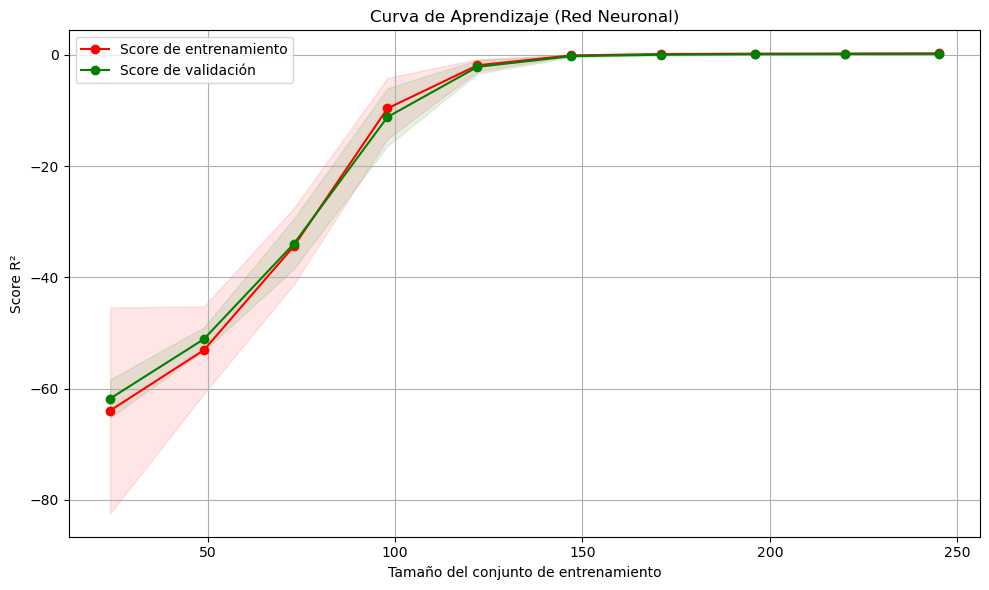

In [50]:


train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_modelANN,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='r2',
    n_jobs=1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de entrenamiento")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validación")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.title("Curva de Aprendizaje (Red Neuronal)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
y_pred_train = best_modelANN.predict(X_train_scaled)
y_pred_testANN = best_modelANN.predict(X_test_scaled)

# Evaluaciones
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_testANN)
r2_test = r2_score(y_test, y_pred_testANN)
mse_test = mean_squared_error(y_test, y_pred_testANN)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_testANN)




In [52]:
results.append({
    "Modelo": "Redes Neuronales (tuned)",  
    "MAE Train": mae_train,
    "MSE Train": mse_train,
    "RMSE Train": rmse_train,
    "R2 Train": r2_train,
    "MAPE Train": mape_train,
    "MAE Test": mae_test,
    "MSE Test": mse_test,
    "RMSE Test": rmse_test,
    "R2 Test": r2_test,
    "MAPE Test": mape_test
})


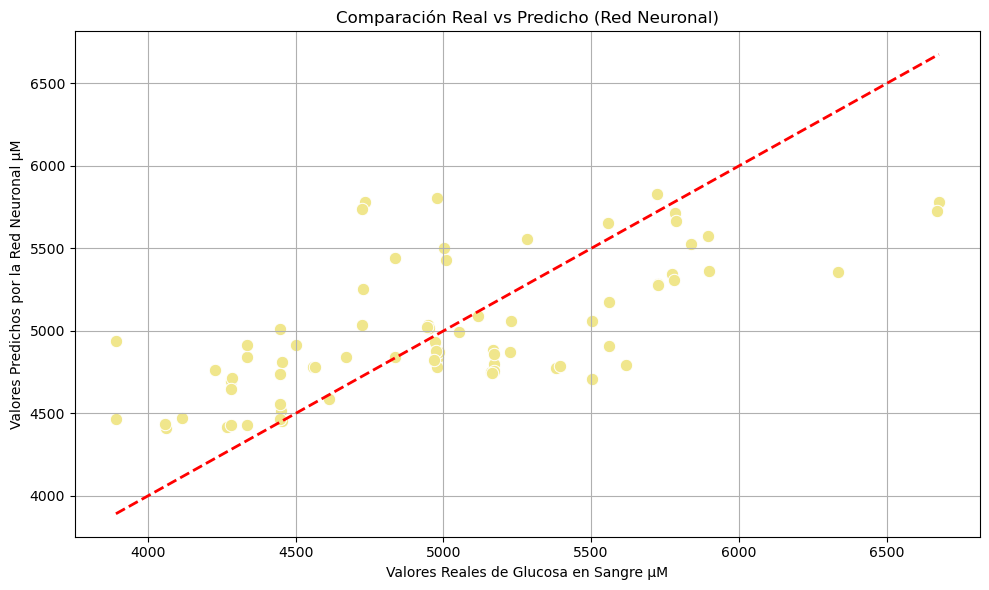

In [53]:
# Comparación real vs predicho
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_testANN.flatten(), color="#F0E68C", edgecolor="white", s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales de Glucosa en Sangre µM")
plt.ylabel("Valores Predichos por la Red Neuronal µM")
plt.title("Comparación Real vs Predicho (Red Neuronal)")
plt.grid(True)
plt.tight_layout()
plt.show()



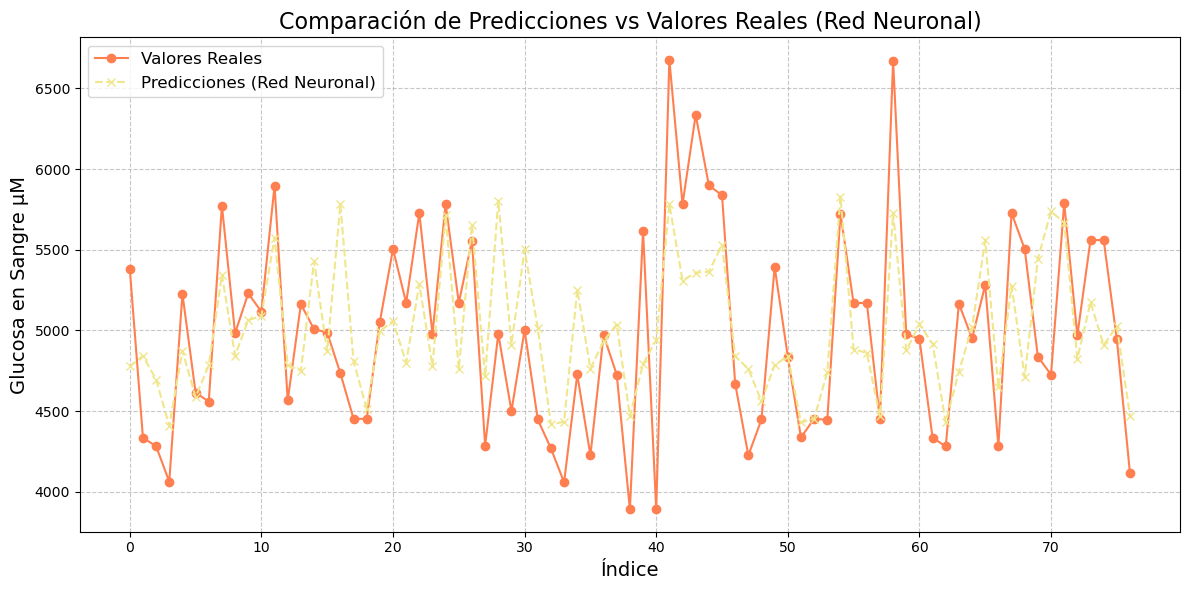

In [54]:
# Comparación línea por índice
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Valores Reales", marker='o', linestyle='-', color='#FF7F50')
plt.plot(y_pred_testANN, label="Predicciones (Red Neuronal)", marker='x', linestyle='--', color='#F0E68C')
plt.legend(fontsize=12)
plt.xlabel("Índice", fontsize=14)
plt.ylabel("Glucosa en Sangre µM", fontsize=14)
plt.title("Comparación de Predicciones vs Valores Reales (Red Neuronal)", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



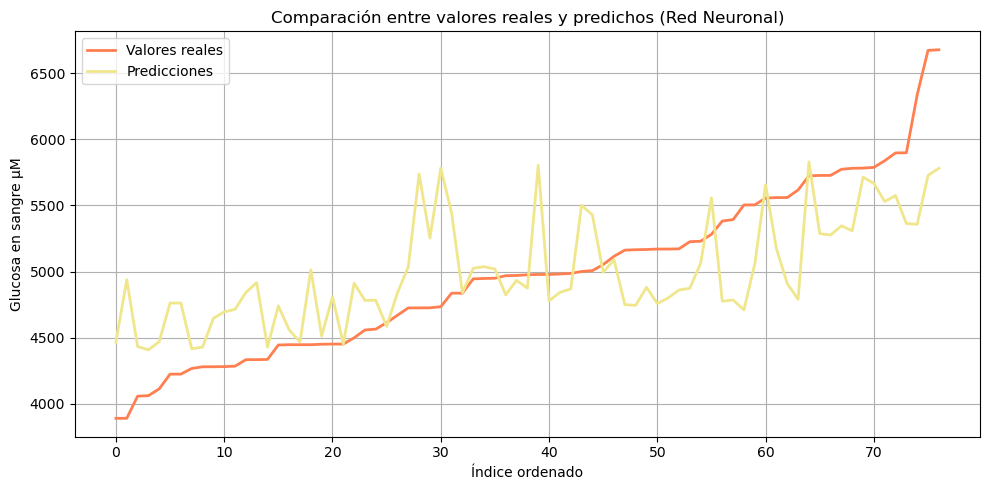

In [55]:
# Ordenado por valor real
sorted_indices = np.argsort(y_test)
y_test_sorted = np.array(y_test)[sorted_indices]
y_pred_sorted = y_pred_testANN.flatten()[sorted_indices]

plt.figure(figsize=(10, 5))
plt.plot(y_test_sorted, label='Valores reales', linewidth=2, color="#FF7F50")
plt.plot(y_pred_sorted, label='Predicciones', linewidth=2, color="#F0E68C")
plt.title('Comparación entre valores reales y predichos (Red Neuronal)')
plt.xlabel('Índice ordenado')
plt.ylabel('Glucosa en sangre µM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:


perm_importance = permutation_importance(
    best_modelANN, 
    X_test_scaled, 
    y_test,
    scoring=make_scorer(r2_score),
    n_repeats=10,
    random_state=42,
    n_jobs=1  
)

In [57]:
importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df)


             feature  importance_mean  importance_std
3      activity_bike         4.273085        0.378785
5  Technique_current         3.743971        0.345116
2   activity_Running         3.620927        0.348926
1        glucose(µM)         0.151302        0.027018
4  activity_crossfit         0.060263        0.043136
0           sweat_ph         0.043967        0.027511


In [58]:
# ------------------- MODELO 4: Random Forest -------------------
# Definir y entrenar modelo Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,  
    max_depth=10,  
    min_samples_split=2,  
    min_samples_leaf=3,  
    random_state=42
)

rf_model.fit(X_train, y_train)



RandomForestRegressor(max_depth=10, min_samples_leaf=3, n_estimators=200,
                      random_state=42)

In [59]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, 8],
    'min_samples_split': [2, 5, 8, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)
best_rf = grid.best_estimator_  # El mejor modelo

Mejores parámetros: {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [60]:
# Validación cruzada con 10 folds
rf_scores = cross_val_score(best_rf, X, y, cv=10, scoring='neg_mean_absolute_error')
print(f'MAE promedio (Random Forest): {-rf_scores.mean()}')
print(f"MAE std: {rf_scores.std():.4f}")

MAE promedio (Random Forest): 421.8335974029049
MAE std: 125.8503


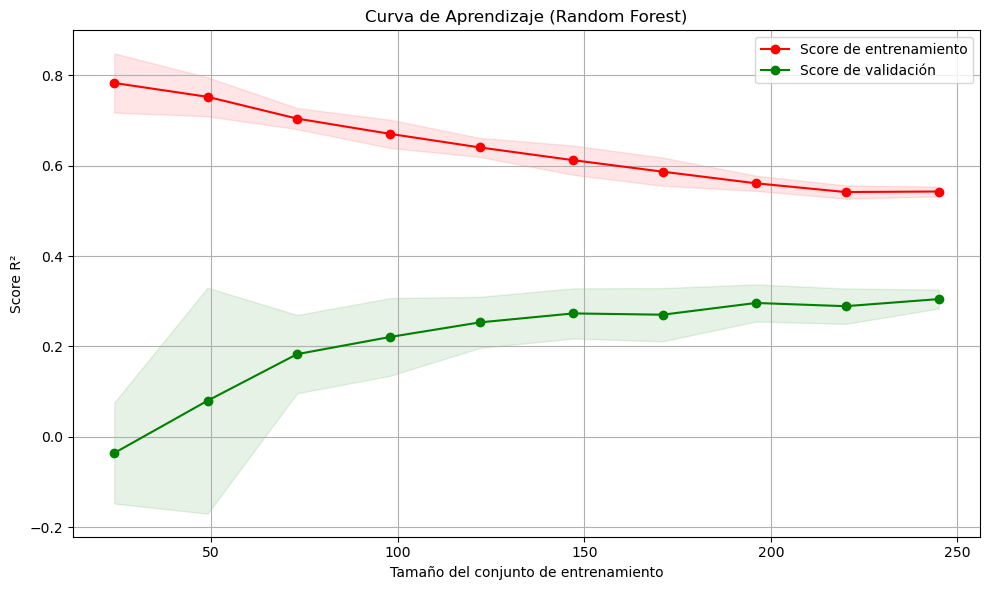

In [61]:
# Generar curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_rf,  
    X=X_train,  # Usar X_train_scaled
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='r2',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de entrenamiento")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validación")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.title("Curva de Aprendizaje (Random Forest)")  # Cambiar el título
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
# Predicciones en el conjunto de entrenamiento y prueba
y_pred_train = best_rf.predict(X_train)
y_pred_testRF = best_rf.predict(X_test)

In [63]:
#EVALUACIÓN DEL MODELO

In [64]:
# Evaluación del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

# Evaluación del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_pred_testRF)
r2_test = r2_score(y_test, y_pred_testRF)
mse_test = mean_squared_error(y_test, y_pred_testRF)

# Calcular RMSE y MAPE
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_testRF)

print(f"Evaluación en Conjunto de Entrenamiento:")
print(f"MAE: {mae_train:.2f}, R²: {r2_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}")

print(f"\nEvaluación en Conjunto de Prueba:")
print(f"MAE: {mae_test:.2f}, R²: {r2_test:.2f}, MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}")

Evaluación en Conjunto de Entrenamiento:
MAE: 340.35, R²: 0.52, MSE: 180532.36, RMSE: 424.89, MAPE: 0.07

Evaluación en Conjunto de Prueba:
MAE: 333.96, R²: 0.52, MSE: 184112.50, RMSE: 429.08, MAPE: 0.07


In [65]:
# Añadir resultados a una lista de resultados
results.append({
    "Modelo": "Random Forest",  
    
    "MAE Train": mae_train,
    "MSE Train": mse_train,
    "RMSE Train": rmse_train,
    "R2 Train": r2_train,
    "MAPE Train": mape_train,

    "MAE Test": mae_test,
    "MSE Test": mse_test,
    "RMSE Test": rmse_test,
    "R2 Test": r2_test,
    "MAPE Test": mape_test
})


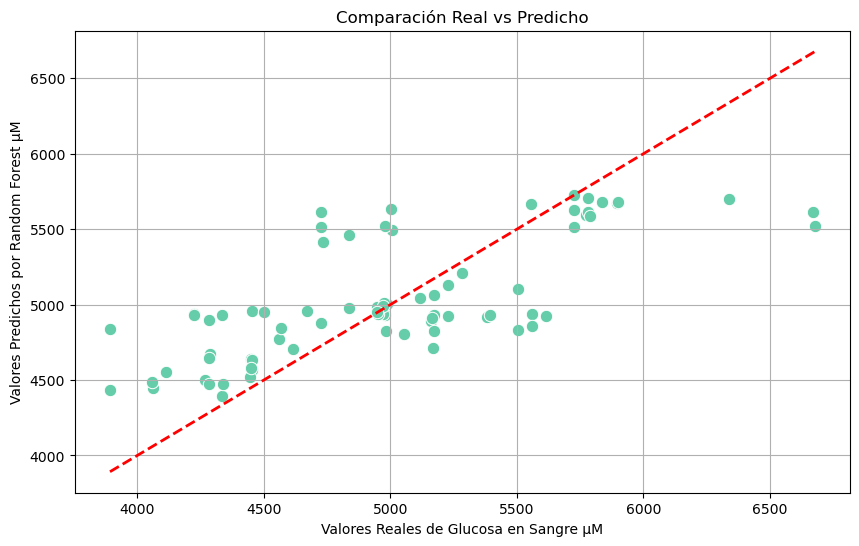

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_testRF, color="#66CDAA", edgecolor="white", s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales de Glucosa en Sangre µM")
plt.ylabel("Valores Predichos por Random Forest µM")
plt.title("Comparación Real vs Predicho")
plt.grid(True)
plt.show()

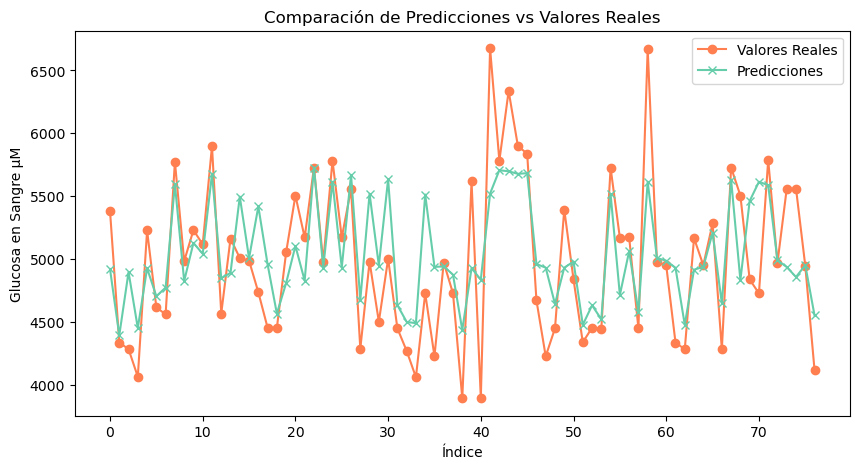

In [67]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Valores Reales", marker='o', color="#FF7F50")
plt.plot(y_pred_testRF, label="Predicciones", marker='x', color="#66CDAA")
plt.legend()
plt.xlabel("Índice")
plt.ylabel("Glucosa en Sangre µM")
plt.title("Comparación de Predicciones vs Valores Reales")
plt.show()

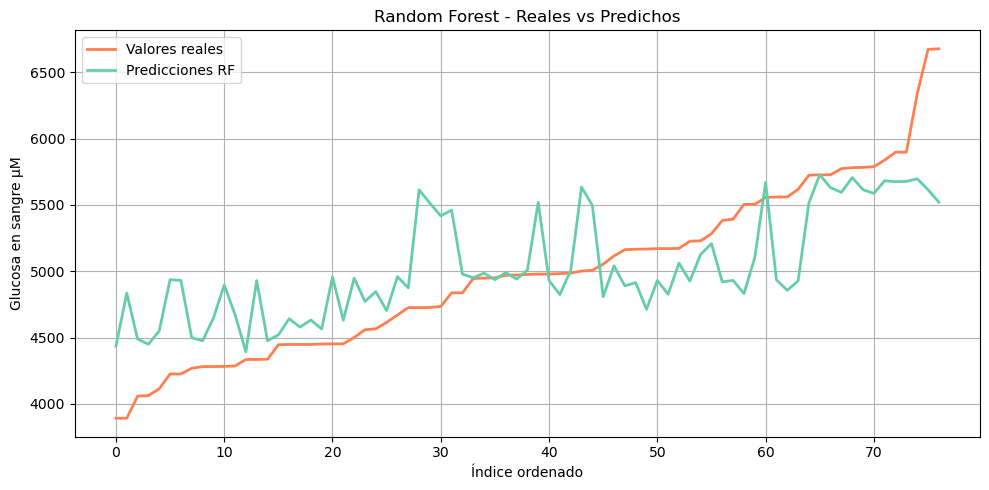

In [68]:
# Ordenar y graficar
sorted_idx_rf = np.argsort(y_test)
plt.figure(figsize=(10, 5))
plt.plot(np.array(y_test)[sorted_idx_rf], label='Valores reales', linewidth=2, color="#FF7F50")
plt.plot(y_pred_testRF[sorted_idx_rf], label='Predicciones RF', linewidth=2, color="#66CDAA")
plt.title('Random Forest - Reales vs Predichos')
plt.xlabel('Índice ordenado')
plt.ylabel('Glucosa en sangre µM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
importances = rf_model.feature_importances_
for feat, imp in zip(X.columns, importances):
    print(f"{feat}: {imp:.4f}")

sweat_ph: 0.1499
glucose(µM): 0.5045
activity_Running: 0.0114
activity_bike: 0.2665
activity_crossfit: 0.0002
Technique_current: 0.0675


In [70]:
# ------------------- MODELO 5: KNN -------------------
# Crear una instancia del modelo KNN para regresión
knn_regressor = KNeighborsRegressor(n_neighbors=5)  # Usamos KNeighborsRegressor para regresión

# Entrenar el modelo
knn_regressor.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [71]:
# Definir el rango de hiperparámetros que vamos a probar
param_grid = {
    'n_neighbors': list(range(1, 200, 1)),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

# Usar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train_scaled, y_train)

# Imprimir los mejores parámetros y el mejor score
print(f"Mejores parámetros: {grid_search.best_params_}")

# Obtener el modelo con los mejores hiperparámetros
best_knn = grid_search.best_estimator_

Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


In [72]:
# Validación cruzada con 10 folds
knn_scores = cross_val_score(best_knn, X_scaled, y, cv=10, scoring='neg_mean_absolute_error')
print(f'MAE promedio (KNN): {-knn_scores.mean()}')
print(f"MAE std: {knn_scores.std():.4f}")

MAE promedio (KNN): 448.97165807876337
MAE std: 112.7321


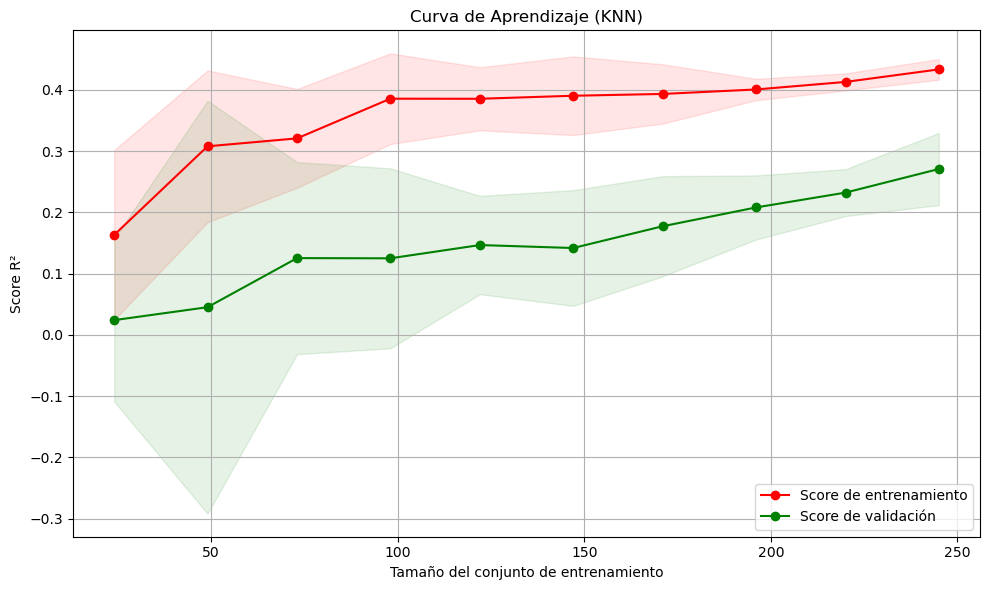

In [73]:
# Generar curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_knn,  
    X=X_train_scaled,  # Usar X_train_scaled
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='r2',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de entrenamiento")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validación")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.title("Curva de Aprendizaje (KNN)")  # Cambiar el título
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
# Predicciones en el conjunto de entrenamiento y prueba
y_pred_train = best_knn.predict(X_train_scaled)
y_pred_testKNN = best_knn.predict(X_test_scaled)

In [75]:
#EVALUACIÓN DEL MODELO

In [76]:
# Evaluación del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

# Evaluación del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_pred_testKNN)
r2_test = r2_score(y_test, y_pred_testKNN)
mse_test = mean_squared_error(y_test, y_pred_testKNN)

# Calcular RMSE y MAPE
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_testKNN)

print(f"Evaluación en Conjunto de Entrenamiento:")
print(f"MAE: {mae_train:.2f}, R²: {r2_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}")

print(f"\nEvaluación en Conjunto de Prueba:")
print(f"MAE: {mae_test:.2f}, R²: {r2_test:.2f}, MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}")

Evaluación en Conjunto de Entrenamiento:
MAE: 362.02, R²: 0.44, MSE: 211437.73, RMSE: 459.82, MAPE: 0.07

Evaluación en Conjunto de Prueba:
MAE: 352.48, R²: 0.45, MSE: 212221.02, RMSE: 460.67, MAPE: 0.07


In [77]:
# Añadir resultados a una lista de resultados
results.append({
    "Modelo": "KNN",  
    
    "MAE Train": mae_train,
    "MSE Train": mse_train,
    "RMSE Train": rmse_train,
    "R2 Train": r2_train,
    "MAPE Train": mape_train,

    "MAE Test": mae_test,
    "MSE Test": mse_test,
    "RMSE Test": rmse_test,
    "R2 Test": r2_test,
    "MAPE Test": mape_test
})


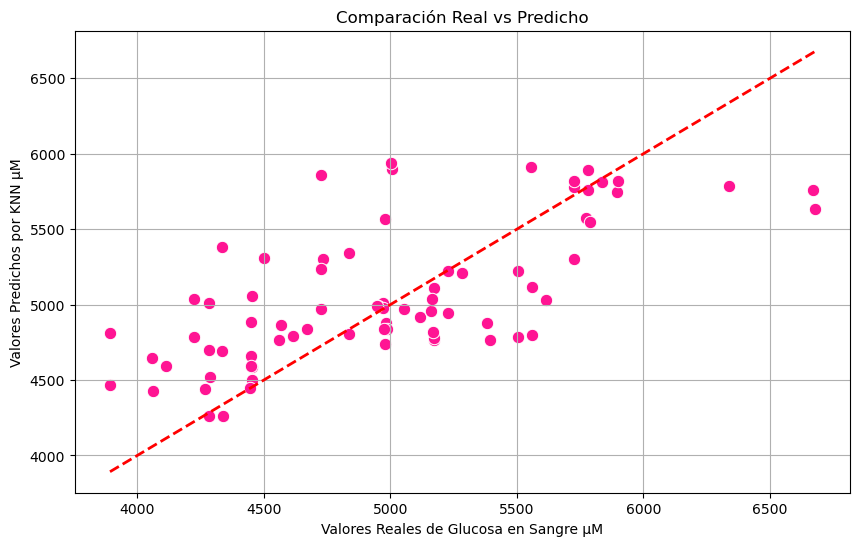

In [78]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_testKNN, color="#FF1493", edgecolor="white", s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales de Glucosa en Sangre µM")
plt.ylabel("Valores Predichos por KNN µM")
plt.title("Comparación Real vs Predicho")
plt.grid(True)
plt.show()

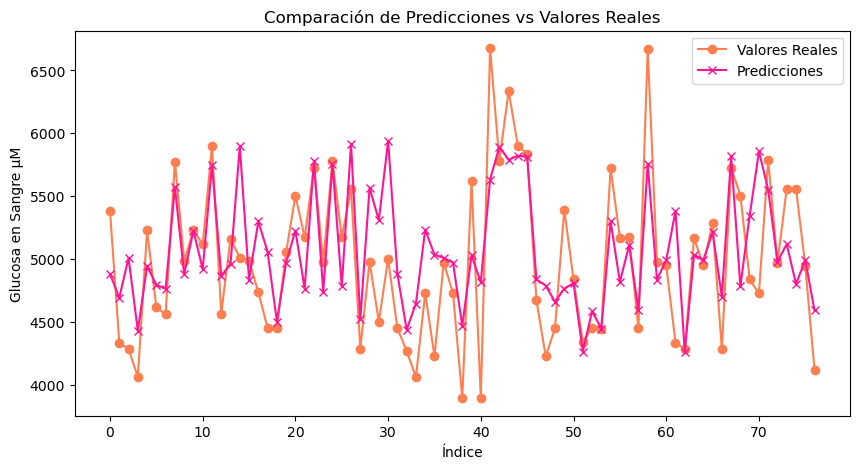

In [79]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Valores Reales", marker='o', color="#FF7F50")
plt.plot(y_pred_testKNN, label="Predicciones", marker='x', color="#FF1493")
plt.legend()
plt.xlabel("Índice")
plt.ylabel("Glucosa en Sangre µM")
plt.title("Comparación de Predicciones vs Valores Reales")
plt.show()

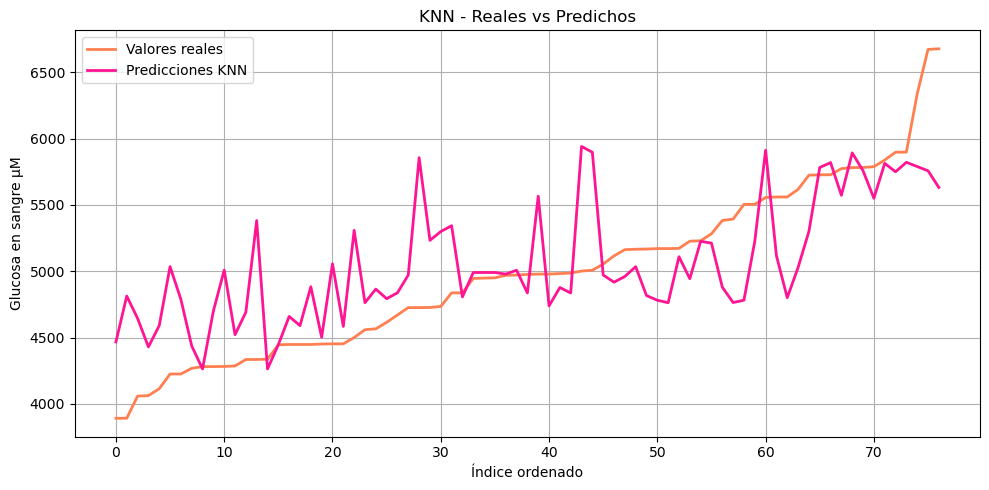

In [80]:
# Ordenar y graficar
sorted_idx_knn = np.argsort(y_test)
plt.figure(figsize=(10, 5))
plt.plot(np.array(y_test)[sorted_idx_knn], label='Valores reales', linewidth=2, color="#FF7F50")
plt.plot(y_pred_testKNN[sorted_idx_knn], label='Predicciones KNN', linewidth=2, color="#FF1493")
plt.title('KNN - Reales vs Predichos')
plt.xlabel('Índice ordenado')
plt.ylabel('Glucosa en sangre µM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
# ------------------- MODELO 6: ElasticNet -------------------
# Crear y entrenar el modelo ElasticNet
model = ElasticNet(random_state=42)

In [82]:
# Definir la cuadrícula de hiperparámetros
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 2.0, 5.0, 7.5, 10.0],  # fuerza de la regularización
    'l1_ratio': [0.1,0.2,0.3,0.4, 0.5,0.6, 0.7,0.8, 0.9, 1.0]  # proporción entre L1 (Lasso) y L2 (Ridge)
}

# Búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)  # Usamos datos escalados

# Mejores hiperparámetros
print(f'Mejores hiperparámetros: {grid_search.best_params_}')
best_modelElastic = grid_search.best_estimator_

Mejores hiperparámetros: {'alpha': 5.0, 'l1_ratio': 1.0}


In [83]:
# Validación cruzada
scores = cross_val_score(best_modelElastic, X_scaled, y, cv=10, scoring='r2', n_jobs=-1)
print(f'MAE promedio (validación cruzada): {-scores.mean():.4f}')
print(f"MAE std: {scores.std():.4f}")

MAE promedio (validación cruzada): 0.6613
MAE std: 1.2810


In [84]:
# Predicciones en el conjunto de entrenamiento y prueba
y_pred_train = best_modelElastic.predict(X_train_scaled)
y_pred_testEN = best_modelElastic.predict(X_test_scaled)

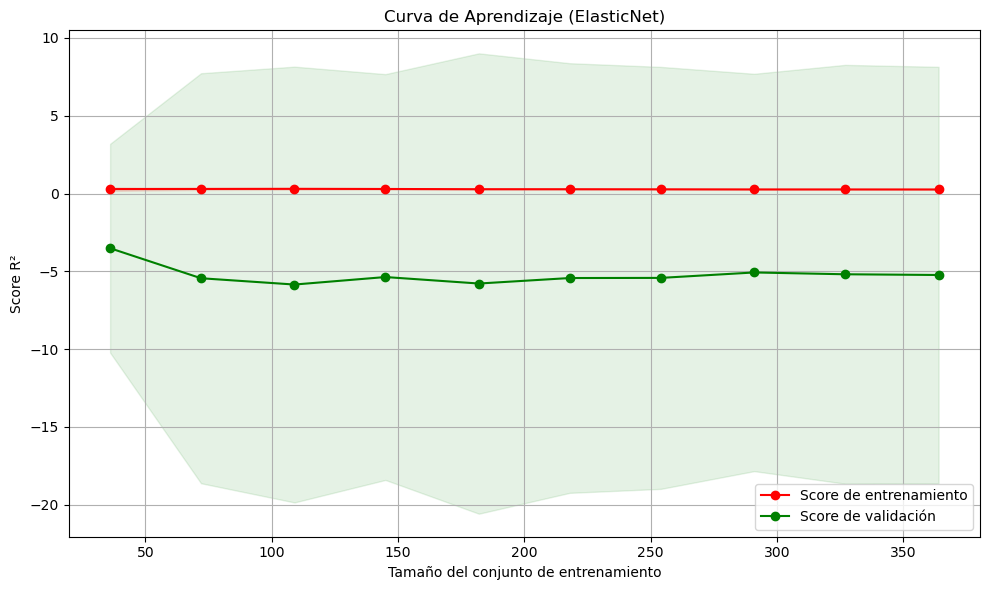

In [85]:
# Generar curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_modelElastic,
    X=X_scaled,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=20,
    scoring='r2',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de entrenamiento")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validación")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.title("Curva de Aprendizaje (ElasticNet)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
# Evaluación del modelo en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

# Evaluación del modelo en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_pred_testEN)
r2_test = r2_score(y_test, y_pred_testEN)
mse_test = mean_squared_error(y_test, y_pred_testEN)

# Calcular RMSE y MAPE
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_testEN)

print(f"Evaluación en Conjunto de Entrenamiento:")
print(f"MAE: {mae_train:.2f}, R²: {r2_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}")

print(f"\nEvaluación en Conjunto de Prueba:")
print(f"MAE: {mae_test:.2f}, R²: {r2_test:.2f}, MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}")

Evaluación en Conjunto de Entrenamiento:
MAE: 455.80, R²: 0.23, MSE: 292017.28, RMSE: 540.39, MAPE: 0.09

Evaluación en Conjunto de Prueba:
MAE: 418.75, R²: 0.37, MSE: 243501.91, RMSE: 493.46, MAPE: 0.09


In [87]:
# Añadir resultados a una lista de resultados
results.append({
    "Modelo": "Elastic Net",  
    
    "MAE Train": mae_train,
    "MSE Train": mse_train,
    "RMSE Train": rmse_train,
    "R2 Train": r2_train,
    "MAPE Train": mape_train,

    "MAE Test": mae_test,
    "MSE Test": mse_test,
    "RMSE Test": rmse_test,
    "R2 Test": r2_test,
    "MAPE Test": mape_test
})


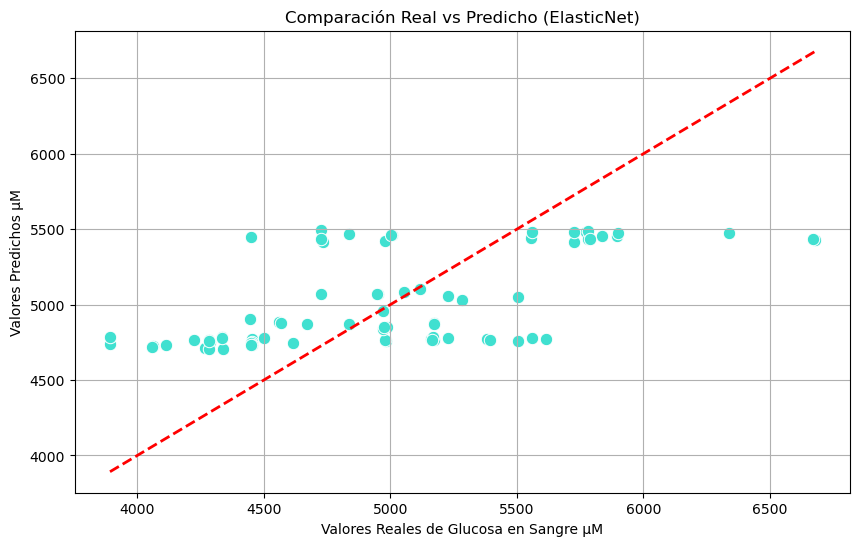

In [88]:
# Gráfica Real vs Predicho
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_testEN, color="#40E0D0", edgecolor="white", s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales de Glucosa en Sangre µM")
plt.ylabel("Valores Predichos µM")
plt.title("Comparación Real vs Predicho (ElasticNet)")
plt.grid(True)
plt.show()

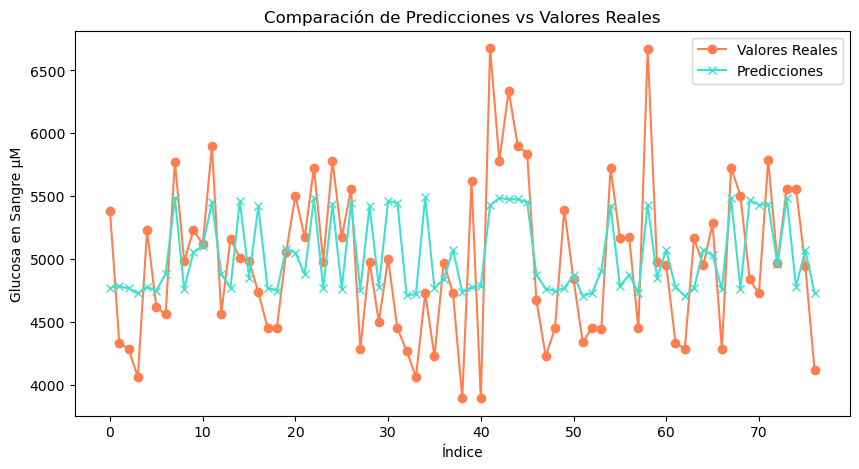

In [89]:
# Gráfica de evolución
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Valores Reales", marker='o', color="#FF7F50")
plt.plot(y_pred_testEN, label="Predicciones", marker='x', color="#40E0D0")
plt.legend()
plt.xlabel("Índice")
plt.ylabel("Glucosa en Sangre µM")
plt.title("Comparación de Predicciones vs Valores Reales")
plt.show()

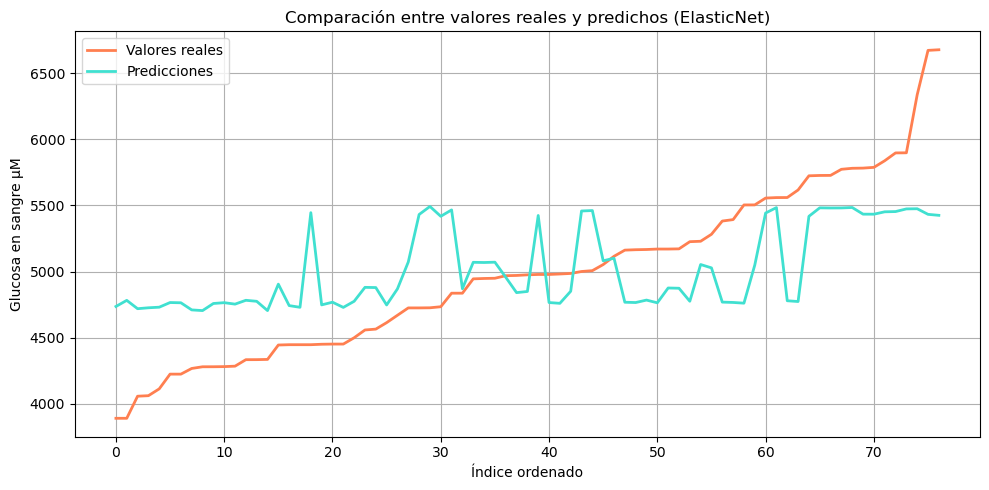

In [90]:
# Ordenar para una mejor visualización
sorted_indices = np.argsort(y_test)
y_test_sorted = np.array(y_test)[sorted_indices]
y_pred_sorted = y_pred_testEN[sorted_indices]

plt.figure(figsize=(10, 5))
plt.plot(y_test_sorted, label='Valores reales', linewidth=2, color="#FF7F50")
plt.plot(y_pred_sorted, label='Predicciones', linewidth=2, color="#40E0D0")
plt.title('Comparación entre valores reales y predichos (ElasticNet)')
plt.xlabel('Índice ordenado')
plt.ylabel('Glucosa en sangre µM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

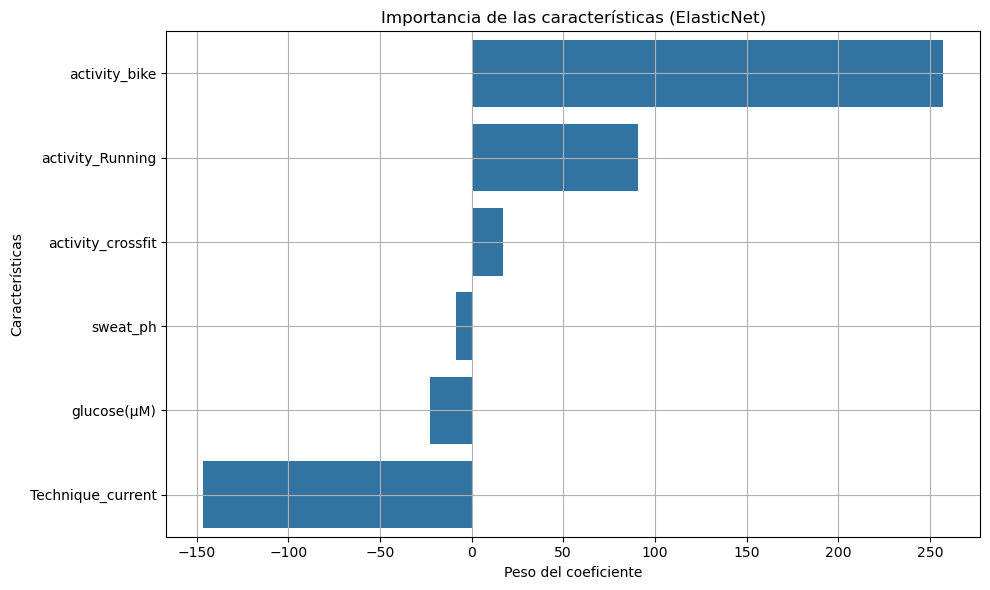

In [91]:
# Importancia de características: usando los coeficientes
feature_importance = pd.Series(best_modelElastic.coef_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Importancia de las características (ElasticNet)')
plt.xlabel('Peso del coeficiente')
plt.ylabel('Características')
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
#TABLA COMPARATIVA DEL R^2 MAE MSE RMSE Y MAPE DE TODOS LOS MODELOS

In [93]:
metrics_df = pd.DataFrame(results)
display(metrics_df)

,Modelo,MAE Train,MSE Train,RMSE Train,R2 Train,MAPE Train,MAE Test,MSE Test,RMSE Test,R2 Test,MAPE Test
0,XGBoost,309.586158,157553.224636,396.929748,0.582618,0.063423,340.778015,204175.822245,451.858188,0.470648,0.069108
1,SVR,395.369359,254945.738889,504.921518,0.324611,0.080229,343.516648,195817.467844,442.512675,0.492318,0.068766
2,Redes Neuronales (tuned),430.088642,268170.072939,517.851400,0.289578,0.087389,373.171852,212219.267979,460.672626,0.449794,0.075094
3,Random Forest,340.345105,180532.360372,424.890998,0.521743,0.069449,333.956451,184112.503841,429.083330,0.522665,0.068055
4,KNN,362.021702,211437.727289,459.823583,0.439870,0.074375,352.478578,212221.024223,460.674532,0.449790,0.072447
5,Elastic Net,455.796479,292017.277875,540.386230,0.226403,0.092993,418.748167,243501.913913,493.459131,0.368690,0.085294


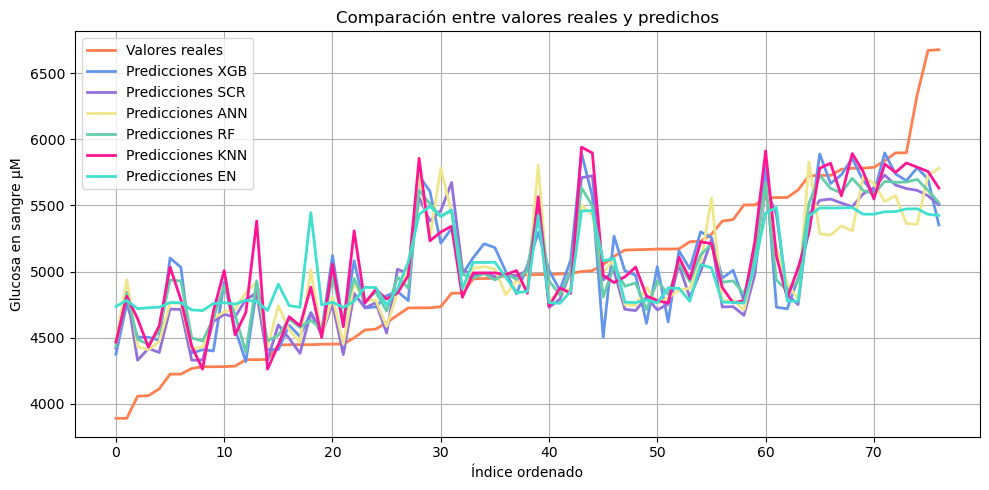

In [94]:
# Ordenar para una mejor visualización
sorted_indices = np.argsort(y_test)
y_test_sorted = np.array(y_test)[sorted_indices]
y_pred_sorted1 = y_pred_testXGB[sorted_indices]
y_pred_sorted2 = y_pred_testSVR[sorted_indices]
y_pred_sorted3 = y_pred_testANN[sorted_indices]
y_pred_sorted4 = y_pred_testRF[sorted_indices]
y_pred_sorted5 = y_pred_testKNN[sorted_indices]
y_pred_sorted6 = y_pred_testEN[sorted_indices]

plt.figure(figsize=(10, 5))
plt.plot(y_test_sorted, label='Valores reales', linewidth=2, color="#FF7F50")
plt.plot(y_pred_sorted1, label='Predicciones XGB', linewidth=2, color="#6495ED")
plt.plot(y_pred_sorted2, label='Predicciones SCR', linewidth=2, color="#9370DB")
plt.plot(y_pred_sorted3, label='Predicciones ANN', linewidth=2, color="#F0E68C")
plt.plot(y_pred_sorted4, label='Predicciones RF', linewidth=2, color="#66CDAA")
plt.plot(y_pred_sorted5, label='Predicciones KNN', linewidth=2, color="#FF1493")
plt.plot(y_pred_sorted6, label='Predicciones EN', linewidth=2, color="#40E0D0")
plt.title('Comparación entre valores reales y predichos')
plt.xlabel('Índice ordenado')
plt.ylabel('Glucosa en sangre µM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()